# Hyperparameter Search
Use Bayesian optimization to find (learning-rate and momentum). The advantage of bayesian optimization compared to grid/random search is that those methods are less sample efficient compared to bayesian optimization.

#### References
* https://en.wikipedia.org/wiki/Bayesian_optimization
* https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
* https://ax.dev
* https://ax.dev/tutorials/tune_cnn.html
* https://botorch.org
* https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf
* http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from typing import Dict, Tuple
import torch.utils.data as utils
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
# Library for augmentations on batch of numpy/tensors
from imgaug import augmenters as iaa
import lamb as lb

import sat_utils
import seg_loss
import seg_metrics
import seg_models

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print('Device:', device)
num_gpu = torch.cuda.device_count()
print('Number of GPUs Available:', num_gpu)

lr=1e-6 #0.001 0.0001-(Good with Dice, 0.007 training)
l2_norm=0.0000001
gamma=0.1
batch_size = 600 #600 #32 #20
num_epochs = 50
step_size = 200

writer = None

ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

### Load Data from pickle (Bad not scalable) and create data loader

In [2]:
X = sat_utils.read_pickle_data('./data/input.pickle')
Y = sat_utils.read_pickle_data('./data/label.pickle')

# Convert dictionaries to numpy array
X = np.stack([sat_utils.get_rgb(x) for x in X.values()])
#X = np.stack([sat_utils.get_rgbi(x) for x in X.values()])
Y = np.stack([(x/255.0) for x in Y.values()])
# Select only mask and between buildings
Y = np.stack([Y[:, 0, :, :], Y[:, 1, :, :]], axis=1)

# Split train/validation
X_t, X_v, Y_t, Y_v = train_test_split(X, Y, test_size=1/10, random_state=42)
print('X_t:', X_t.shape)
print('Y_t:', Y_t.shape)
print('X_v:', X_v.shape)
print('Y_v:', Y_v.shape)

# Changes on label for Cross-Entropy (3 classes all mixed on the same image, N,W,H)
# Changes on label for BCEWithLogitsLoss (3 classes on 3 Channels, N,C,W,H)
tensor_x_t = torch.Tensor(X_t)
tensor_y_t = torch.Tensor(Y_t)
tensor_x_v = torch.Tensor(X_v)
tensor_y_v = torch.Tensor(Y_v)

# Define some augmentations
seq_augm = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Flipud(0.5), # vertically flip 50% of the images
    #iaa.Affine(rotate=(-10, 10)), # Rotate the images
])

dataset_train = utils.TensorDataset(tensor_x_t,tensor_y_t)
dataset_val = utils.TensorDataset(tensor_x_v,tensor_y_v)
dataloader_train = utils.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = utils.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

num_classes = tensor_y_t.shape[1]

X_t: (2038, 3, 76, 76)
Y_t: (2038, 2, 76, 76)
X_v: (227, 3, 76, 76)
Y_v: (227, 2, 76, 76)


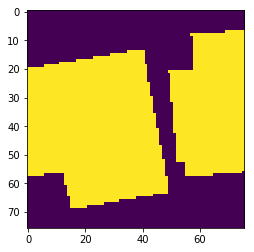

In [3]:
import matplotlib.pyplot as plt
plt.imshow(Y[2000,0,:,:])

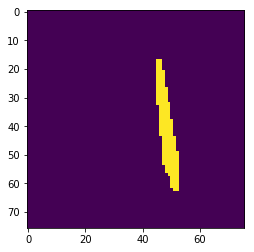

In [4]:
plt.imshow(Y[2000,1,:,:])

#### Define Train Function
Train the model for one epoch given:
* Train loader
* Parameters
* Validation loader (Just to debug)

In [6]:
def train(train_loader: DataLoader, val_loader: DataLoader, parameters: Dict[str, float], dtype: torch.dtype, device: torch.device) -> nn.Module:
    # Start Tensorboard interface
    global writer
    writer = SummaryWriter()
    
    # Initialize Model and optimizer
    model = seg_models.AtrousSeg(num_classes=num_classes, num_channels=tensor_x_t.shape[1])
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    model.to(device)
    
    # Define loss and optimizer
    #optimizer = optim.SGD(model.parameters(), lr=parameters.get("lr", 0.001), momentum=parameters.get("momentum", 0.9))
    base_lr = parameters.get("lr", 0.001)
    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=l2_norm)
    #optimizer = lb.Lamb(model.parameters(), lr=base_lr, weight_decay=0.01, betas=(.9, .99), adam=True)
    criterion = nn.BCEWithLogitsLoss()
    
    # Decrease learning rate if some metric doesnt change for "patience" epochs
    scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=False)
    
    lw_bce = parameters.get("loss_weight_bce", 1.0)
    lw_iou = parameters.get("loss_weight_iou", 1.0)
    lw_dice = parameters.get("loss_weight_dice", 1.0)
    # Print parameters of loss weight
    writer.add_scalar('bce_weight/', lw_bce, 0)
    writer.add_scalar('iou_weight/', lw_iou, 0)
    writer.add_scalar('dice_weight/', lw_dice, 0)
    writer.add_scalar('base_lr/', base_lr, 0)
    
    model.train()
    
    # Train Network
    iteration_count = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for (imgs, labels) in train_loader:

            # Do augmentations the augmentation library expect numpy arrays on format Batch x Row x Cols x Channels
            imgs_aug, labels_aug = seq_augm(images=np.moveaxis(imgs.numpy(),1,3), heatmaps=np.moveaxis(labels.numpy(),1,3))

            # Move axis back and convert back to tensor
            imgs = torch.from_numpy(np.moveaxis(imgs_aug,3,1))
            labels = torch.from_numpy(np.moveaxis(labels_aug,3,1))

            # Send inputs/labels to GPU                
            labels = labels.to(device)
            imgs = imgs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs)
            dice_value  = seg_loss.dice_loss(outputs, labels)
            ioU_value  = seg_loss.iou_loss(outputs, labels)
            bce_value = criterion(outputs, labels)
            loss = (lw_bce*bce_value) + (lw_dice*dice_value) + (lw_iou*ioU_value)
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            writer.add_scalar('loss/', loss.item(), iteration_count)
            writer.add_scalar('dice_loss/', dice_value.item(), iteration_count)
            iteration_count+=1  
        
        # Finished epoch
        # Get current learning rate (To display on Tensorboard)
        for param_group in optimizer.param_groups:
            curr_learning_rate = param_group['lr']
            writer.add_scalar('learning_rate/', curr_learning_rate, epoch)
        
        # Evaluate model after epoch
        model.eval()
        list_iou_val = []
        with torch.no_grad():
            for (imgs, labels) in val_loader:
                # Send inputs/labels to GPU                
                labels = labels.to(device)
                imgs = imgs.to(device)                
                outputs = model(imgs)
                iou_value = seg_metrics.iou(outputs, labels)
                # Append IoU val for each batch of of data from validation
                list_iou_val.append(iou_value.item())

        # Report IoU mean 
        iou_val = np.mean(list_iou_val)
        writer.add_scalar('iou_val_run/', np.mean(list_iou_val), epoch)
        
        # Step learning rate scheduler
        scheduler_plateau.step(running_loss)
    return model

#### Define Evaluation Function
Evaluate the model given:
* Some Model
* Data Loader
This function will run after the end of the train trial, which basically will guide the optimizer.

In [7]:
def evaluate(model: nn.Module, val_loader: DataLoader, dtype: torch.dtype, device: torch.device) -> float:    
    global writer 
    model.eval()
    list_iou_val = []
    with torch.no_grad():
        for (imgs, labels) in val_loader:
            # Send inputs/labels to GPU                
            labels = labels.to(device)
            imgs = imgs.to(device)                
            outputs = model(imgs)
            iou_value = seg_metrics.iou(outputs, labels)
            # Append IoU val for each batch of of data from validation
            list_iou_val.append(iou_value.item())
    
    # Report IoU mean 
    iou_val = np.mean(list_iou_val)
    writer.add_scalar('iou_val/', np.mean(list_iou_val), 0)

    return iou_val

#### Define our objective Function
This is the function we want to optimize given it's parameters. We want to find the parameters that will maximize accuracy on the validation set.

In [8]:
def objective_func(parameterization):
    model = train(train_loader=dataloader_train, val_loader = dataloader_val, 
                  parameters=parameterization, dtype=torch.float, device=device)
    return evaluate(
        model=model,
        val_loader=dataloader_val,
        dtype=torch.float,
        device=device,
    )

#### Run Bayesian Optimizer
Search for best learning rate and momentum hyperparameters.

In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-5, 1e-1], "log_scale": True},
        {"name": "bce_weight", "type": "range", "bounds": [0.0, 1.0]},
        {"name": "iou_weight", "type": "range", "bounds": [0.0, 1.0]},
        {"name": "dice_weight", "type": "range", "bounds": [0.0, 1.0]},
    ],
    evaluation_function=objective_func,
    objective_name='IoU',
    total_trials=40, # Optional.
)

[INFO 06-02 17:32:23] ax.service.utils.dispatch: Using Bayesian Optimization generation strategy. Iterations after 5 will take longer to generate due to model-fitting.
[INFO 06-02 17:32:23] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 06-02 17:32:23] ax.service.managed_loop: Running optimization trial 1...
[INFO 06-02 18:01:38] ax.service.managed_loop: Running optimization trial 2...
[INFO 06-02 18:30:13] ax.service.managed_loop: Running optimization trial 3...
[INFO 06-02 22:28:45] ax.service.managed_loop: Running optimization trial 11...


#### Show Results

In [ ]:
print('Best parameters:',best_parameters)
print('IoU:', values)
#render(plot_contour(model=model, param_x='lr', param_y='momentum', metric_name='accuracy'))

In [ ]:
1+1

In [ ]:
1+1

In [ ]:
1+12

In [ ]:
1+1